In [14]:
import json
import os
import sys
import time
import numpy as np
import pandas as pd

from types import SimpleNamespace


from data_tools.TSdataset import TimeSeriesDataset_MultiCSV_train_Production

from tools.inference_utils import FinCast_Inference, plot_last_outputs

In [15]:
#paths to set up

# data path -> #path to your data
# model_path -> #the pth file for model path
# save_output_path -> #path for saving your outputs.

import glob

# Auto-detect input file in input/ folder
input_folder = r"d:\Projects\Python\Fincast\FinCast-fts\input"
# Find all csvs
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
# IMPORTANT: Filter out files with "_val_input" in name, as those are temporary files generated by validation step
csv_files = [f for f in csv_files if "_val_input" not in f]

if csv_files:
    # Use the most recently modified file so it picks up what prepare_inference_data.py just created
    data_path = max(csv_files, key=os.path.getmtime)
    print(f"Auto-selected data file: {data_path}")
else:
    data_path = "" 
    print("WARNING: No CSV file found in input/ folder. Please run prepare_inference_data.py")


# Pointing to the model inside checkpoints folder
model_path = r"d:\Projects\Python\Fincast\FinCast-fts\checkpoints\v1.pth"            #the pth file for model path

save_output_path = r"d:\Projects\Python\Fincast\FinCast-fts\output"          #path for saving your outputs.

Auto-selected data file: d:\Projects\Python\Fincast\FinCast-fts\input\600869.SH.csv


In [16]:
## set up 

config = SimpleNamespace()

#device
config.backend = "gpu"                    #cpu for cpu only, gpu for cuda gpu

#model path
config.model_path = model_path

#model version
config.model_version = "v1"           #only v1 for now, v1 is the 1b model in cikm 2025 paper, will release a better v2 soon with better performance and smaller size


#data related
config.data_path = data_path
config.data_frequency = "m"       #supports from second to year, use s for second, y for year and so for
config.context_len = 256             #input length for forecast input, from 32 to 1024
config.horizon_len =  16           #output length for forecast output, from 1 to 256

config.all_data = False               #boolean, False => only use the last input(input = context length), True =>  stride = 1, slices all input data and inference

config.columns_target = ['Close']             #the columns which you want to forecast, can use both int (index of that column) or str for column name

config.series_norm = False            #True for norm each series, false for not norm.

config.batch_size = 64                #go lower if you have a smaller vram.


#output related
config.forecast_mode = "mean"         #mean or median
config.quantile_outputs = []          #put in the optional quantile outputs you want, from q1 to q9, leave empty for nothing


config.save_output = True            #saves numeric outputs to csv
config.save_output_path = save_output_path

config.plt_outputs = True             #plt all the last outputs
config.plt_quantiles = [1, 3, 7, 9]             #quantiles to plt, from 1 to 9, use int



In [17]:
# === 验证模式数据准备 (Backtest Data Prep) ===
# 为了验证模型的准确性，我们将数据的最后一段（horizon_len长度）切分出来作为“标准答案”(Ground Truth)
# 模型只能看到切分后的前半部分数据，我们用它来预测被切掉的那部分，从而对比效果。

import pandas as pd

# 读取原始完整数据
full_df = pd.read_csv(config.data_path)
h_len = config.horizon_len

if len(full_df) > h_len:
    print(f"原始数据长度: {len(full_df)}")
    print(f"隐藏最后 {h_len} 个时间点作为验证集(Ground Truth)...")
    
    # 1. 提取验证集（真实的未来）
    ground_truth_df = full_df.iloc[-h_len:].copy() 
    ground_truth_values = ground_truth_df[config.columns_target[0]].values
    
    # 2. 提取输入集（给模型的历史）
    input_df = full_df.iloc[:-h_len].copy()
    
    # 3. 保存临时的输入文件供模型读取
    val_file_path = config.data_path.replace(".csv", "_val_input.csv")
    input_df.to_csv(val_file_path, index=False)
    
    # 4. 关键：更新 config 让模型读取这个被截断的文件
    original_data_path = config.data_path # backup
    config.data_path = val_file_path
    
    print(f"临时输入文件已生成: {val_file_path}")
    print(f"模型将使用截至 {input_df.iloc[-1]['date']} 的数据进行推理")
    print(f"预测目标时间段: {ground_truth_df.iloc[0]['date']} 到 {ground_truth_df.iloc[-1]['date']}")
    
else:
    print("错误：数据长度不足以进行切分验证。")

原始数据长度: 2000
隐藏最后 16 个时间点作为验证集(Ground Truth)...
临时输入文件已生成: d:\Projects\Python\Fincast\FinCast-fts\input\600869.SH_val_input.csv
模型将使用截至 2026-01-09 14:44:00 的数据进行推理
预测目标时间段: 2026-01-09 14:45:00 到 2026-01-09 15:00:00


In [18]:
#auto run code, just run this cell
fincast_inference = FinCast_Inference(config)


preds, mapping, full_outputs = fincast_inference.run_inference()




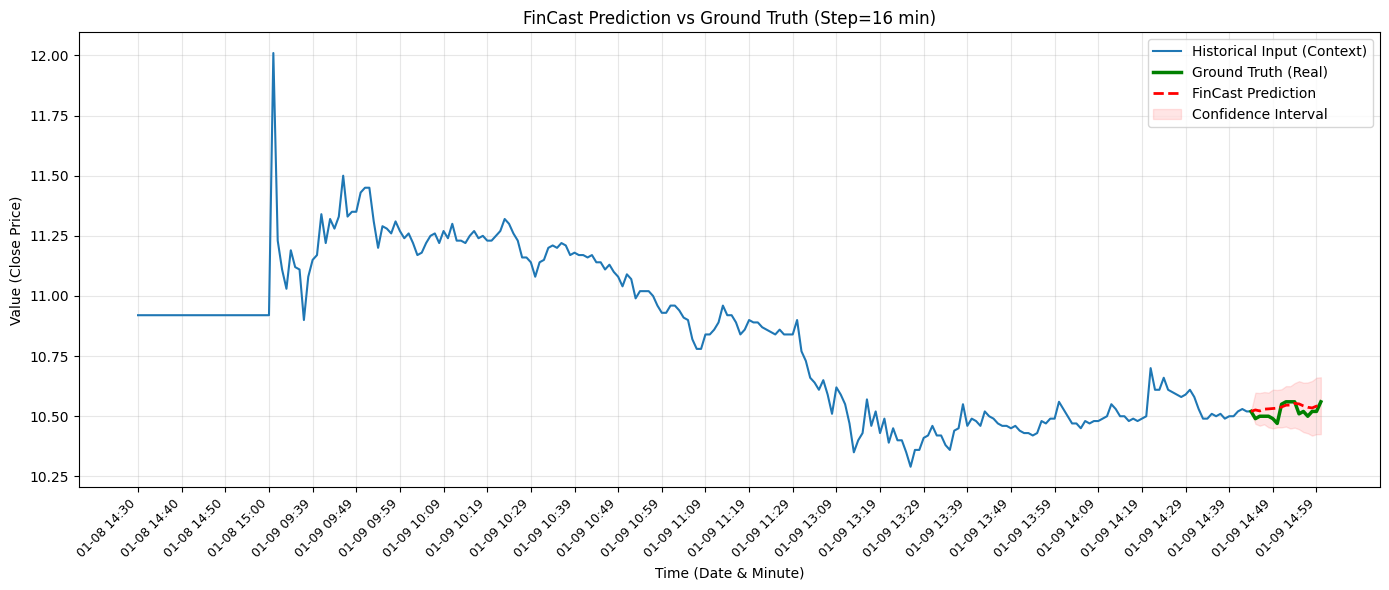

In [19]:
# === 结果对比可视画 (Comparison Plot) ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

if getattr(config, "plt_outputs", True):
    # 1. 获取模型看到的历史数据 (Context)
    ctx_len = config.context_len
    dataset_obj = fincast_inference.inference_dataset
    context_values = dataset_obj.series_arrays[0][-ctx_len:]
    
    # 2. 获取模型预测结果 (Prediction)
    pred_values = preds[0] 
    
    # 3. 准备索引坐标 (Index Coordinates) - 使用整数索引以避免显示时间空缺
    x_ctx = np.arange(len(context_values))
    x_fut = np.arange(len(context_values), len(context_values) + len(pred_values))

    # --- 修复断层 (Fix Gap) ---
    # 为了让线条连续，我们将历史数据的最后一点作为预测/真实值的起始点
    x_connect = np.concatenate(([x_ctx[-1]], x_fut))
    last_ctx_val = context_values[-1]
    
    # 准备日期标签
    has_dates = False
    all_dates = None

    if 'input_df' in locals() and 'ground_truth_df' in locals():
        try:
            if not pd.api.types.is_datetime64_any_dtype(input_df['date']):
                input_df['date'] = pd.to_datetime(input_df['date'])
            if not pd.api.types.is_datetime64_any_dtype(ground_truth_df['date']):
                ground_truth_df['date'] = pd.to_datetime(ground_truth_df['date'])
                
            ctx_dates = input_df['date'].iloc[-len(context_values):].values
            fut_dates = ground_truth_df['date'].iloc[:len(pred_values)].values
            
            # 将所有日期拼在一起，用于生成标签
            all_dates = np.concatenate([ctx_dates, fut_dates])
            has_dates = True
        except Exception as e:
            print(f"无法获取日期信息: {e}")

    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # A. 画历史数据 (使用整数索引)
    ax.plot(x_ctx, context_values, label="Historical Input (Context)", color="#1f77b4", linewidth=1.5)
    
    # B. 画真实值
    if 'ground_truth_values' in locals() and len(ground_truth_values) == len(pred_values):
        # 连接历史最后一点
        gt_connect = np.concatenate(([last_ctx_val], ground_truth_values))
        ax.plot(x_connect, gt_connect, label="Ground Truth (Real)", color="green", linewidth=2.5)
    
    # C. 画预测值
    # 连接历史最后一点
    pred_connect = np.concatenate(([last_ctx_val], pred_values))
    ax.plot(x_connect, pred_connect, label="FinCast Prediction", color="red", linestyle="--", linewidth=2)
    
    # D. 分位数
    if full_outputs is not None:
        from tools.inference_utils import _validate_quantile_requests
        full_sel = full_outputs[0:1]
        req_qs = getattr(config, "plt_quantiles", [])
        qmap = _validate_quantile_requests(full_sel, req_qs)
        
        if qmap:
             lowest_q_idx = qmap[0][1]
             highest_q_idx = qmap[-1][1]
             y_low = full_sel[0, :, lowest_q_idx]
             y_high = full_sel[0, :, highest_q_idx]
             
             # 连接历史最后一点
             y_low_connect = np.concatenate(([last_ctx_val], y_low))
             y_high_connect = np.concatenate(([last_ctx_val], y_high))
             ax.fill_between(x_connect, y_low_connect, y_high_connect, color='red', alpha=0.1, label="Confidence Interval")

    ax.set_title(f"FinCast Prediction vs Ground Truth (Step={len(pred_values)} min)")
    ax.set_ylabel("Value (Close Price)")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)
    
    # === 这里的修改：增加 X 轴标签密度 ===
    if has_dates and all_dates is not None:
        total_len = len(all_dates)
        # 增加刻度数量，例如尝试每 20 个点显示一个标签，或者至少显示 25 个标签
        num_ticks = 25 
        step = max(1, total_len // num_ticks)
        
        # 生成刻度位置 (基于整数索引 0 到 total_len)
        tick_indices = np.arange(0, total_len, step)
        
        # 从 all_dates 中取出对应的日期字符串
        tick_labels = [pd.to_datetime(all_dates[i]).strftime('%m-%d %H:%M') for i in tick_indices]
        
        ax.set_xticks(tick_indices)
        ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=9) # 旋转45度并稍微缩小字体
        ax.set_xlabel("Time (Date & Minute)")
    else:
        ax.set_xlabel("Time Steps (Minutes)")

    plt.tight_layout()
    plt.show()